## 1. Importing Required Libraries
We start by importing essential libraries:
- **PyTorch** for deep learning model creation and training.
- **Torchvision** for datasets, image transformations, and utilities.
- **itertools** for efficient looping.
- **Matplotlib** and **NumPy** for data visualization and numerical operations.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
import numpy as np


## 2. Mounting Google Drive
We mount Google Drive to access our datasets and pre-trained model checkpoints stored in the cloud.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Defining the ResNet Generator
We implement a **ResNet-based Generator** for the CycleGAN model:
- **Reflection padding** to minimize edge artifacts.
- **Downsampling** layers to reduce spatial dimensions.
- **ResNet blocks** with skip connections to preserve important image details.
- **Upsampling** layers to restore the image size.


In [ ]:
#######Generator##########
#########################

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=9, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf #no of generator filters
        #n_blocks = resnet blocks

        #Initial convlutional block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        # Downsample
        #reducing spatial dimensions
        n_downsampling = 2 #no. of downsampling layers
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=True),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        # Resnet blocks
        #using shortcut connections bypassing few layers
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type='reflect', norm_layer=norm_layer, use_dropout=use_dropout, use_bias=True)]

        # Upsample
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)
#resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        # Create the convolutional block
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)
    #function to build convolution block
    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = [] #to hold layers
        p = 0

        #determining padding type for first layer
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        else:
            p = 1  # 'zero' padding
        #first convolution layer
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        #opyional dropout layer
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        #determining padding type for 2nd layer
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        else:
            p = 1  # 'zero' padding
        #second convolutional block
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

## 4. Defining the Custom Discriminator (VGG16-based)
We create a custom **Discriminator** using a pre-trained VGG16 network:
- Extracts features from images using the convolutional part of VGG16.
- Performs **binary classification** (fake vs real).
- Performs **multi-class classification** (benign vs malignant).


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomDiscriminator(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDiscriminator, self).__init__()
        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Remove the classifier part of VGG16
        self.features = vgg16.features

        # Calculate the size of the feature map after VGG16 features
        # Assuming input image size of (3, 224, 224)
        self.feature_map_size = 512 * 7 * 7

        # Define the classifier for fake/real
        self.fake_real_classifier = nn.Sequential(
            nn.Linear(self.feature_map_size, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1),  # Binary classification (fake/real)
            nn.Sigmoid()
        )

        # Define the classifier for benign/malignant
        self.benign_malignant_classifier = nn.Sequential(
            nn.Linear(self.feature_map_size, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)  # Multi-class classification (benign/malignant)
        )

    def forward(self, x):
        # Extract features using VGG16
        features = self.features(x)
        features = features.view(features.size(0), -1)  # Flatten the feature map

        # Fake/Real classification
        fake_real_output = self.fake_real_classifier(features)

        # Benign/Malignant classification
        benign_malignant_output = self.benign_malignant_classifier(features)

        return fake_real_output, benign_malignant_output


## 5. Setting Hyperparameters
We define:
- **Number of input/output channels**.
- **Number of ResNet blocks** for the generator.
- **Learning rate** and **Adam optimizer β₁ parameter**.


In [ ]:
input_nc = 3  # number of channels in the input images
output_nc = 3  # number of channels in the output images
n_residual_blocks = 9  # typical number for a CycleGAN

lr = 0.0002
beta1 = 0.5

## 6. Selecting Device
We check if a GPU is available and set the device for training and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 7. Defining Image Transformations
We define preprocessing steps for input images:
- Convert to PyTorch tensor.
- Resize to **224×224**.
- Normalize pixel values to range **[-1, 1]**.


In [ ]:
#Sequence of transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 8. Loading Test Datasets
We load separate test datasets for:
- **Benign images**.
- **Malignant images**.
Each is wrapped in a DataLoader for easy iteration.


In [ ]:
# Load test datasets
test_dataset_A = datasets.ImageFolder(root='/content/drive/MyDrive/test/benign', transform=transform)  # Load benign test dataset
test_dataset_B = datasets.ImageFolder(root='/content/drive/MyDrive/test/malignant', transform=transform)  # Load malignant test dataset

# Data loaders
test_loader_A = DataLoader(test_dataset_A, batch_size=1, shuffle=False)
test_loader_B = DataLoader(test_dataset_B, batch_size=1, shuffle=False)


## 9. Loading Pre-trained Models
We load saved CycleGAN model weights for:
- **Generators** (G_A2B, G_B2A).
- **Discriminators** (D_A, D_B).
We also implement a helper function to **ignore mismatched layer shapes** when loading weights.


In [ ]:
# Paths to the saved models
G_A2B_path = '/content/drive/MyDrive/vgg_16_CycleGAN_Models/netG_A2B_epoch_24.pth'
G_B2A_path = '/content/drive/MyDrive/vgg_16_CycleGAN_Models/netG_B2A_epoch_24.pth'
D_A_path = '/content/drive/MyDrive/vgg_16_CycleGAN_Models/netD_A_epoch_24.pth'
D_B_path = '/content/drive/MyDrive/vgg_16_CycleGAN_Models/netD_B_epoch_24.pth'

# Load the models
G_A2B = ResnetGenerator(input_nc,output_nc).to(device)
G_B2A = ResnetGenerator(input_nc,output_nc).to(device)
D_A = CustomDiscriminator(input_nc).to(device)
D_B = CustomDiscriminator(input_nc).to(device)

def load_model_ignore_mismatch(model, state_dict):
    model_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

# Usage example:
# Load the trained models with map_location for CPU
G_A2B.load_state_dict(torch.load(G_A2B_path, map_location=torch.device('cpu')))
G_B2A.load_state_dict(torch.load(G_B2A_path, map_location=torch.device('cpu')))

state_dict_D_A = torch.load(D_A_path, map_location=torch.device('cpu'))
state_dict_D_B = torch.load(D_B_path, map_location=torch.device('cpu'))

load_model_ignore_mismatch(D_A, state_dict_D_A)
load_model_ignore_mismatch(D_B, state_dict_D_B)

#load_model_ignore_mismatch(D_A_path, map_location=torch.device('cpu')))
#load_model_ignore_mismatch(D_B_path, map_location=torch.device('cpu')))

#D_A.load_state_dict(torch.load(D_A_path, map_location=torch.device('cpu')))
#D_B.load_state_dict(torch.load(D_B_path, map_location=torch.device('cpu')))





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.2MB/s]


## 10. Loading Pre-trained FCN Model
We load a **Fully Convolutional Network (FCN-ResNet50)** for semantic segmentation, which will be used to evaluate generated images.


In [ ]:
import torch
import torchvision.models.segmentation as segmentation

# Load pre-trained FCN model
fcn_model = segmentation.fcn_resnet50(pretrained=True).eval().to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 111MB/s]


## 11. Defining Segmentation Metrics - Per Pixel & Per Class Accuracy
We implement:
- **Per Pixel Accuracy (PPA)** – proportion of correctly classified pixels.
- **Per Class Accuracy (PCA)** – average pixel accuracy per class.


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

def calculate_per_pixel_accuracy(seg_map_real, seg_map_fake):
    """
    Calculate Per Pixel Accuracy (PPA).

    Args:
    - seg_map_real (np.array): The real segmentation map.
    - seg_map_fake (np.array): The generated segmentation map.

    Returns:
    - ppa (float): Per Pixel Accuracy.
    """
    return accuracy_score(seg_map_real.flatten(), seg_map_fake.flatten())

def calculate_per_class_accuracy(seg_map_real, seg_map_fake):
    """
    Calculate Per Class Accuracy (PCA).

    Args:
    - seg_map_real (np.array): The real segmentation map.
    - seg_map_fake (np.array): The generated segmentation map.

    Returns:
    - pca (float): Per Class Accuracy.
    """
    labels = np.unique(seg_map_real)
    accuracies = []
    for label in labels:
        mask = seg_map_real == label
        accuracies.append(accuracy_score(seg_map_real[mask], seg_map_fake[mask]))
    return np.mean(accuracies)

# Example usage for a batch of images
ppa_scores = []
pca_scores = []

## 12. Defining IoU Calculation and Segmentation Map Extraction
We add:
- A function to extract **segmentation maps** using the FCN model.
- A function to compute **Intersection over Union (IoU)** for generated vs real segmentation masks.


In [ ]:
import torch
import torchvision.models.segmentation as segmentation
from sklearn.metrics import jaccard_score
import numpy as np

# Load pre-trained FCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fcn_model = segmentation.fcn_resnet50(pretrained=True).eval().to(device)

def get_segmentation_map(image, model):
    if len(image.shape) == 4:
        # Image is already in the correct shape
        input_tensor = image
    elif len(image.shape) == 3:
        # Add batch dimension
        input_tensor = image.unsqueeze(0)
    else:
        raise ValueError(f"Unexpected input shape: {image.shape}")

    with torch.no_grad():
        output = model(input_tensor)['out']
        seg_map = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
    return seg_map

def calculate_iou(seg_map_real, seg_map_fake):
    seg_map_real_flat = seg_map_real.flatten()
    seg_map_fake_flat = seg_map_fake.flatten()
    return jaccard_score(seg_map_real_flat, seg_map_fake_flat, average='macro')

# Example usage for a batch of images
iou_scores = []

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 13. Creating Directories for Saving Images
We prepare directories to save:
- **Generated images** (benign→malignant, malignant→benign).
- **Real test images** for reference.


In [ ]:
import os
from torchvision.utils import save_image
# Directories for saving generated test images
os.makedirs('/content/drive/MyDrive/test_generated_by_vgg16_cyclegan/benign_to_malignant', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_generated_by_vgg16_cyclegan/malignant_to_benign', exist_ok=True)
# Directories for saving real test images
os.makedirs('/content/drive/MyDrive/test_real_by_vgg16_cyclegan/real_benign', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_real_by_vgg16_cyclegan/real_malignant', exist_ok=True)

## 14. Generating Images and Computing Metrics
For each test image pair:
- Generate fake images using the trained generators.
- Save generated and real images.
- Compute:
  - **SSIM** – Structural Similarity Index.
  - **PSNR** – Peak Signal-to-Noise Ratio.
  - **MSE** – Mean Squared Error.
  - **IoU**, **PPA**, and **PCA** using segmentation results.


In [ ]:
import os
import torch
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Function to compute MSE
def mse(img1, img2):
    return F.mse_loss(img1, img2).item()

# Lists to store metrics for generated
ssim_values = []
psnr_values = []
mse_values = []


with torch.no_grad():
    for i, (data_A, data_B) in enumerate(zip(test_loader_A, test_loader_B)):
        print(f'Processing image {i+1}')
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)

        save_image(fake_B, f'/content/drive/MyDrive/test_generated_by_vgg16_cyclegan/benign_to_malignant/{i}.png')
        save_image(fake_A, f'/content/drive/MyDrive/test_generated_by_vgg16_cyclegan/malignant_to_benign/{i}.png')
        save_image(real_A, f'/content/drive/MyDrive/test_real_by_vgg16_cyclegan/real_benign/{i}.png')
        save_image(real_B, f'/content/drive/MyDrive/test_real_by_vgg16_cyclegan/real_malignant/{i}.png')

        # Check shapes before transposing
        print(f'Shape of real_A: {real_A.shape}')
        print(f'Shape of real_B: {real_B.shape}')
        print(f'Shape of fake_A: {fake_A.shape}')
        print(f'Shape of fake_B: {fake_B.shape}')

        # Remove batch dimension and convert images to numpy arrays
        # Convert images to numpy arrays and adjust the range to [0, 1]
        real_A_np = (real_A[0].cpu().numpy().transpose(1, 2, 0) + 1) / 2
        real_B_np = (real_B[0].cpu().numpy().transpose(1, 2, 0) + 1) / 2
        fake_A_np = (fake_A[0].cpu().numpy().transpose(1, 2, 0) + 1) / 2
        fake_B_np = (fake_B[0].cpu().numpy().transpose(1, 2, 0) + 1) / 2


        # Ensure values are within [0, 1]
        real_A_np = np.clip(real_A_np, 0, 1)
        real_B_np = np.clip(real_B_np, 0, 1)
        fake_A_np = np.clip(fake_A_np, 0, 1)
        fake_B_np = np.clip(fake_B_np, 0, 1)


        #For Generated
        # Compute metrics for benign to malignant
        ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
        psnr_value = psnr(real_B_np, fake_B_np)
        mse_value = mse(real_B, fake_B)

        ssim_values.append(ssim_value)
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)

        # Compute metrics for malignant to benign
        ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)
        psnr_value = psnr(real_A_np, fake_A_np)
        mse_value = mse(real_A, fake_A)

        ssim_values.append(ssim_value)
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)

        # Get segmentation maps
        seg_map_real_B = get_segmentation_map(real_B, fcn_model)
        seg_map_fake_B = get_segmentation_map(fake_B, fcn_model)
        seg_map_real_A = get_segmentation_map(real_A, fcn_model)
        seg_map_fake_A = get_segmentation_map(fake_A, fcn_model)

        # Calculate IoU
        iou_B = calculate_iou(seg_map_real_B, seg_map_fake_B)
        iou_A = calculate_iou(seg_map_real_A, seg_map_fake_A)

        iou_scores.append((iou_A + iou_B) / 2)  # Average IoU for both directions

         # Calculate metrics for benign to malignant
        ppa_B = calculate_per_pixel_accuracy(seg_map_real_B, seg_map_fake_B)
        pca_B = calculate_per_class_accuracy(seg_map_real_B, seg_map_fake_B)

        # Calculate metrics for malignant to benign
        ppa_A = calculate_per_pixel_accuracy(seg_map_real_A, seg_map_fake_A)
        pca_A = calculate_per_class_accuracy(seg_map_real_A, seg_map_fake_A)

        # Average metrics for both directions
        ppa_scores.append((ppa_A + ppa_B) / 2)
        pca_scores.append((pca_A + pca_B) / 2)

Processing image 1
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 2
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 3
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 4
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 5
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 6
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 7
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 8
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 9
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 10
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 11
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 12
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 13
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 14
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 15
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 16
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 17
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 18
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 19
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 20
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 21
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 22
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 23
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 24
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 25
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 26
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 27
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 28
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 29
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 30
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 31
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 32
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 33
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 34
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 35
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 36
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 37
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 38
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 39
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 40
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 41
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 42
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 43
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 44
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 45
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 46
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 47
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 48
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 49
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 50
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 51
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 52
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 53
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 54
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 55
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 56
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 57
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 58
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 59
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 60
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 61
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 62
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 63
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 64
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 65
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 66
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 67
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 68
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 69
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 70
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 71
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 72
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 73
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 74
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 75
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 76
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 77
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 78
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 79
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 80
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 81
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 82
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 83
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 84
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 85
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 86
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 87
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 88
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 89
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 90
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 91
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 92
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 93
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 94
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 95
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 96
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 97
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 98
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 99
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 100
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 101
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 102
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 103
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 104
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 105
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 106
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 107
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 108
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 109
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 110
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 111
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 112
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 113
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 114
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 115
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 116
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 117
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 118
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 119
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 120
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 121
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 122
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 123
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 124
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 125
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 126
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 127
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 128
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 129
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 130
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 131
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 132
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 133
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 134
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 135
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 136
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 137
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 138
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 139
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 140
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 141
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 142
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 143
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 144
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 145
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 146
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 147
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 148
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 149
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 150
Shape of real_A: torch.Size([1, 3, 224, 224])
Shape of real_B: torch.Size([1, 3, 224, 224])
Shape of fake_A: torch.Size([1, 3, 224, 224])
Shape of fake_B: torch.Size([1, 3, 224, 224])


<ipython-input-18-9fc1530964de>:61: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-18-9fc1530964de>:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


## 15. Calculating Average Evaluation Metrics
We compute dataset-level averages for:
- **IoU**
- **Per Pixel Accuracy (PPA)**
- **Per Class Accuracy (PCA)**


In [ ]:
# Average IoU for the dataset
average_iou = np.mean(iou_scores)
print(f'Average IoU: {average_iou:.4f}')
# Average metrics for the dataset
average_ppa = np.mean(ppa_scores)
average_pca = np.mean(pca_scores)
print(f'Average Per Pixel Accuracy: {average_ppa:.4f}')
print(f'Average Per Class Accuracy: {average_pca:.4f}')

Average IoU: 0.6787
Average Per Pixel Accuracy: 0.9547
Average Per Class Accuracy: 0.8374


## 16. Plotting SSIM, PSNR, and MSE
We create visualizations to see how these metrics vary across test samples:
- **SSIM plot**
- **PSNR plot**
- **MSE plot**


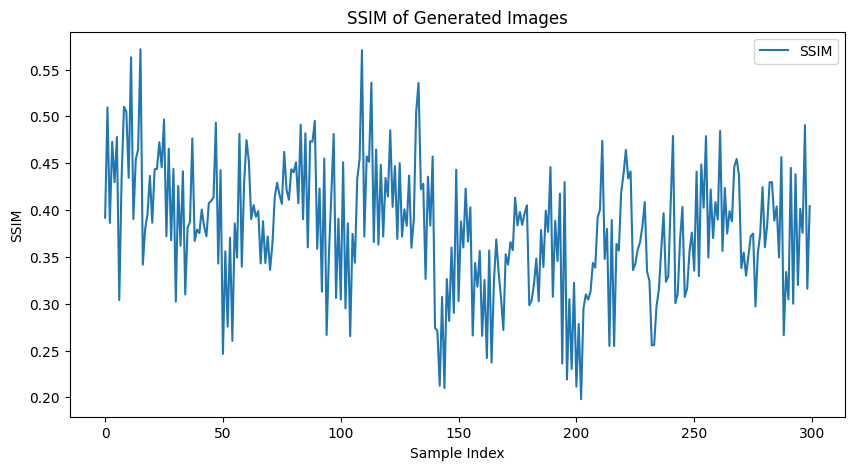

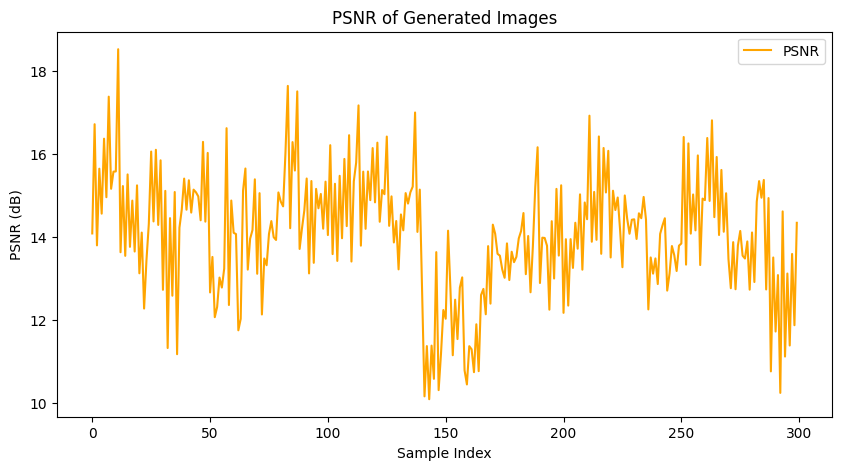

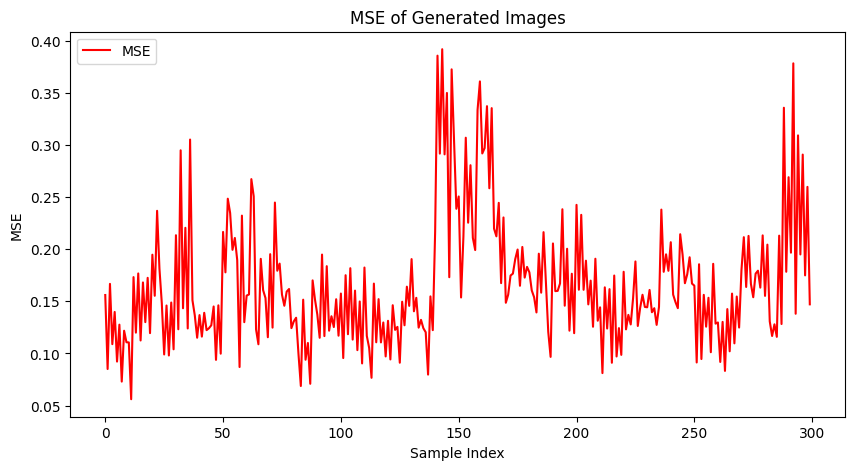

In [ ]:
# Plot SSIM
plt.figure(figsize=(10, 5))
plt.plot(ssim_values, label='SSIM')
plt.xlabel('Sample Index')
plt.ylabel('SSIM')
plt.title('SSIM of Generated Images')
plt.legend()
plt.show()

# Plot PSNR
plt.figure(figsize=(10, 5))
plt.plot(psnr_values, label='PSNR', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('PSNR (dB)')
plt.title('PSNR of Generated Images')
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(10, 5))
plt.plot(mse_values, label='MSE', color='red')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.title('MSE of Generated Images')
plt.legend()
plt.show()

## 17. Function to Compare Real and Generated Images
We define a helper function to display a **real image** side-by-side with its **generated counterpart**.


In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_single_real_and_fake_image(real_image, fake_image):
    """
    Plots a comparison of a single real and a single generated (fake) image.

    Parameters:
    - real_image: a single Tensor image (C, H, W).
    - fake_image: a single Tensor image (C, H, W).
    """
    plt.figure(figsize=(8, 4))

    # Display the real image
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Image")
    real_image = vutils.make_grid(real_image, normalize=True).permute(1, 2, 0).cpu().numpy()
    plt.imshow(real_image)

    # Display the fake image
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Generated Image")
    fake_image = vutils.make_grid(fake_image, normalize=True).permute(1, 2, 0).cpu().numpy()
    plt.imshow(fake_image)

    plt.show()

## 18. Displaying Sample Results
We display a few examples of:
- **Real benign → Generated malignant**
- **Real malignant → Generated benign**


Image :  0


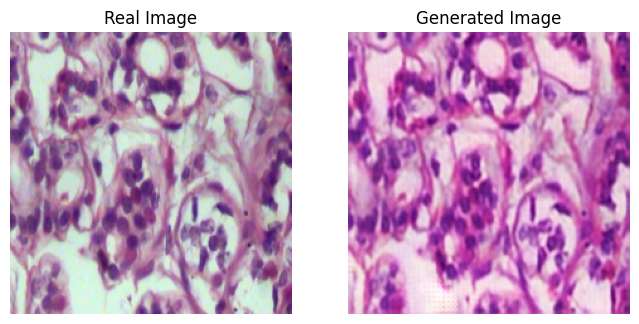

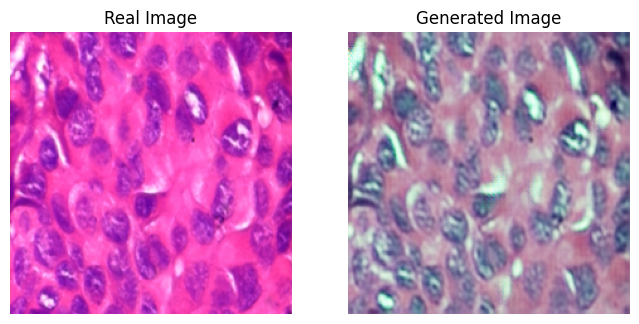

Image :  1


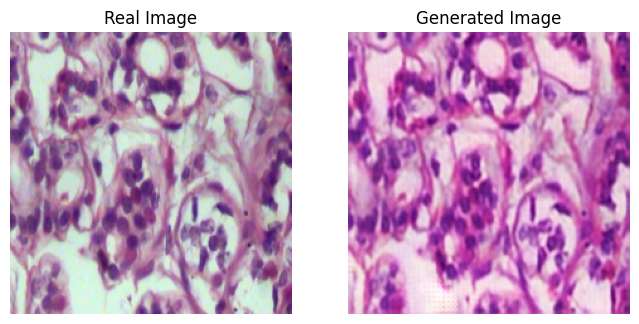

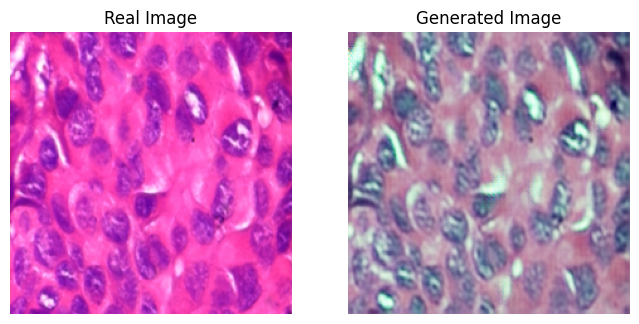

Image :  2


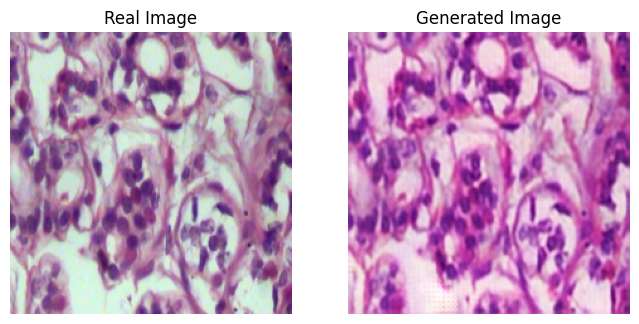

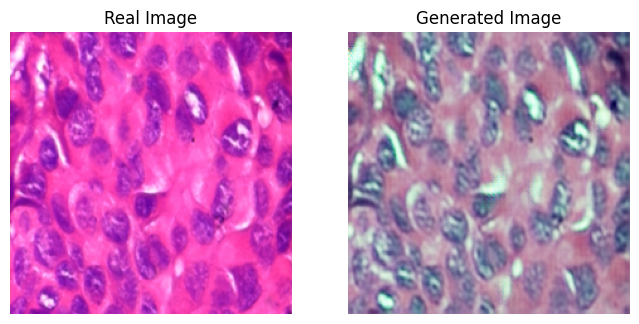

In [ ]:
for i in range(3):
    print("Image : ", i)
    plot_single_real_and_fake_image(real_A[0], fake_B[0])  # Pass the first image of the batch
    plot_single_real_and_fake_image(real_B[0], fake_A[0])